# Imports

['AMT_PAYMENT', 'DAYS_CREDIT_ENDDATE', 'DAYS_FIRST_DRAWING','DAYS_BIRTH_disc_int___19282__13234_',
       'CNT_PAYMENT','DAYS_BIRTH_disc_int___25229__19283_','NAME_EDUCATION_TYPE_discret_lower','EXT_SOURCE_2_disc_int__0_0_0_09_', 'EXT_SOURCE_2_disc_int__0_45_0_85_','REGION_RATING_CLIENT_W_CITY','DAYS_CREDIT_ENDDATE','RATE_DOWN_PAYMENT']
       
Colonnes à traiter dans train_prepared : EXT_SOURCE_2_disc_int (2 modalités) ; DAYS_BIRTH ; NAME_EDUCATION_TYPE ; REGION_RATING_CLIENT_W_CITY ; NAME_CONTRACT_TYPE
Colonnes à traiter dans installment payment : AMT_PAYMENT
Colonnes à traiter dans previous_application : CNT_PAYMENT ; DAYS_FIRST_DRAWING ; RATE_DOWN_PAYMENT
Colonnes à traiter dans bureau : DAYS_CREDIT_ENDDATE

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import zscore
import scipy.stats as stats
from scipy.stats import chi2_contingency
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc
from mlxtend.evaluate import permutation_test
import statsmodels.api as sm

from data_preparation import *
import warnings
warnings.filterwarnings("ignore")

In [79]:
train_prepared = pd.read_csv('./data/train_prepared.csv')
df_app = pd.read_csv('./data/application_train_vf.csv')

train_prepared['SK_ID_CURR'] = df_app['SK_ID_CURR'].copy()
train_prepared['DAYS_BIRTH'] = df_app['DAYS_BIRTH'].copy()
train_prepared['NAME_EDUCATION_TYPE'] = df_app['NAME_EDUCATION_TYPE'].copy()
train_prepared['EXT_SOURCE_2'] = df_app['EXT_SOURCE_2'].copy()
train_prepared['OCCUPATION_TYPE'] = df_app['OCCUPATION_TYPE'].copy()
train_prepared['NAME_INCOME_TYPE'] = df_app['NAME_INCOME_TYPE'].copy()
train_prepared['DEF_30_CNT_SOCIAL_CIRCLE'] = df_app['DEF_30_CNT_SOCIAL_CIRCLE'].copy()
train_prepared['date_mensuelle'] = pd.to_datetime(train_prepared['date_mensuelle'])

train_prepared.drop(columns = 'Unnamed: 0',inplace=True)

train_prepared = train_prepared[['SK_ID_CURR', 'DAYS_BIRTH' , 'NAME_EDUCATION_TYPE' , 'REGION_RATING_CLIENT_W_CITY' , 'NAME_CONTRACT_TYPE','TARGET','date_mensuelle', 'EXT_SOURCE_2' , 'OCCUPATION_TYPE','NAME_INCOME_TYPE','DEF_30_CNT_SOCIAL_CIRCLE' ]]

In [80]:
train_prepared['DEF_30_CNT_SOCIAL_CIRCLE'].isna().sum()

1019

# Bureau

In [81]:
df_bur = pd.read_csv('./data/bureau.csv')

In [82]:
df_bur_group = df_bur[['DAYS_CREDIT_ENDDATE','SK_ID_CURR']].groupby('SK_ID_CURR').sum()
df_bur_group.reset_index(inplace=True)

# Previous_application

In [83]:
df_prev = pd.read_csv('./data/previous_application.csv')

In [84]:
df_prev_group = df_prev[['SK_ID_CURR', 'CNT_PAYMENT' , 'DAYS_FIRST_DRAWING' , 'RATE_DOWN_PAYMENT']].groupby('SK_ID_CURR').sum()
df_prev_group.reset_index(inplace=True)

# Installment

In [85]:
df_ins = pd.read_csv('./data/installments_payments.csv')

In [86]:
df_ins_group = df_ins[['SK_ID_CURR', 'AMT_PAYMENT']].groupby('SK_ID_CURR').sum()
df_ins_group.reset_index(inplace=True)

# Merging

In [87]:
train_prepared = train_prepared.merge(df_bur_group, on = 'SK_ID_CURR', how = 'left')
train_prepared = train_prepared.merge(df_prev_group, on = 'SK_ID_CURR', how = 'left')
train_prepared = train_prepared.merge(df_ins_group, on = 'SK_ID_CURR', how = 'left')

# NaN

In [88]:
for col in train_prepared.columns:
    if train_prepared[col].isna().sum()>100000:
        train_prepared = train_prepared.drop(columns = col)
    elif train_prepared[col].dtype=='object' :
        mode = train_prepared[col].mode()
        train_prepared[col] = train_prepared[col].fillna(mode)
    else : 
        train_prepared[col] = train_prepared[col].fillna(0)

In [89]:
train_prepared.columns

Index(['SK_ID_CURR', 'DAYS_BIRTH', 'NAME_EDUCATION_TYPE',
       'REGION_RATING_CLIENT_W_CITY', 'NAME_CONTRACT_TYPE', 'TARGET',
       'date_mensuelle', 'EXT_SOURCE_2', 'OCCUPATION_TYPE', 'NAME_INCOME_TYPE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'DAYS_CREDIT_ENDDATE', 'CNT_PAYMENT',
       'DAYS_FIRST_DRAWING', 'RATE_DOWN_PAYMENT', 'AMT_PAYMENT'],
      dtype='object')

# Discretisation

Discrétisation des variables numériques en cours ... 


  0%|          | 0/7 [00:00<?, ?it/s]

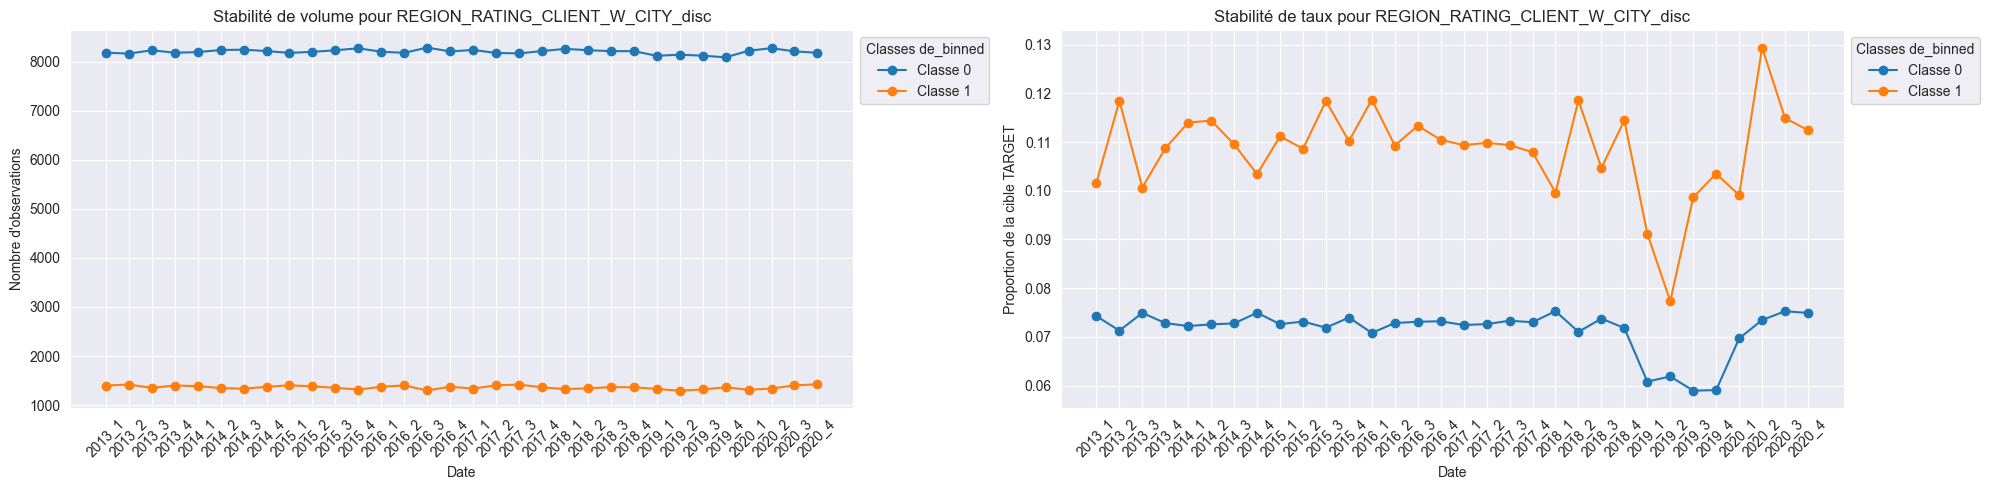

 14%|█▍        | 1/7 [00:19<01:58, 19.74s/it]

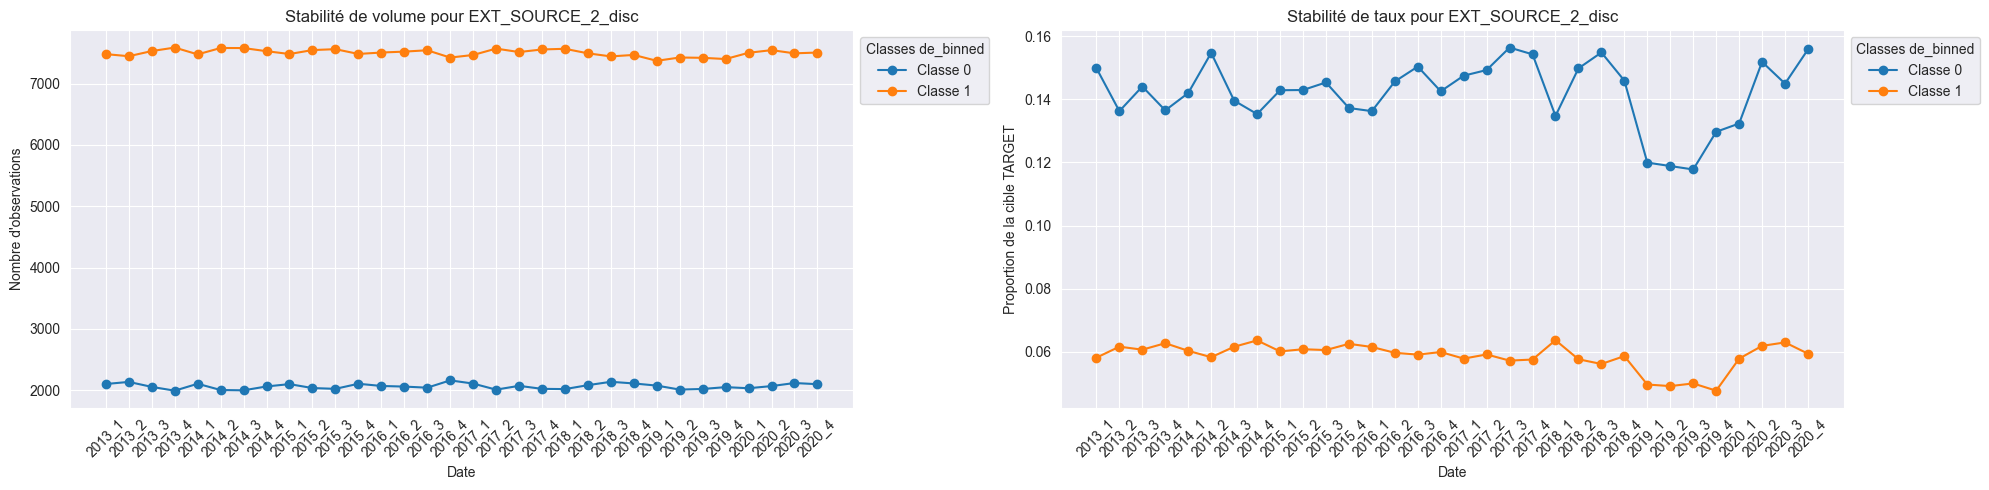

 29%|██▊       | 2/7 [00:37<01:32, 18.50s/it]

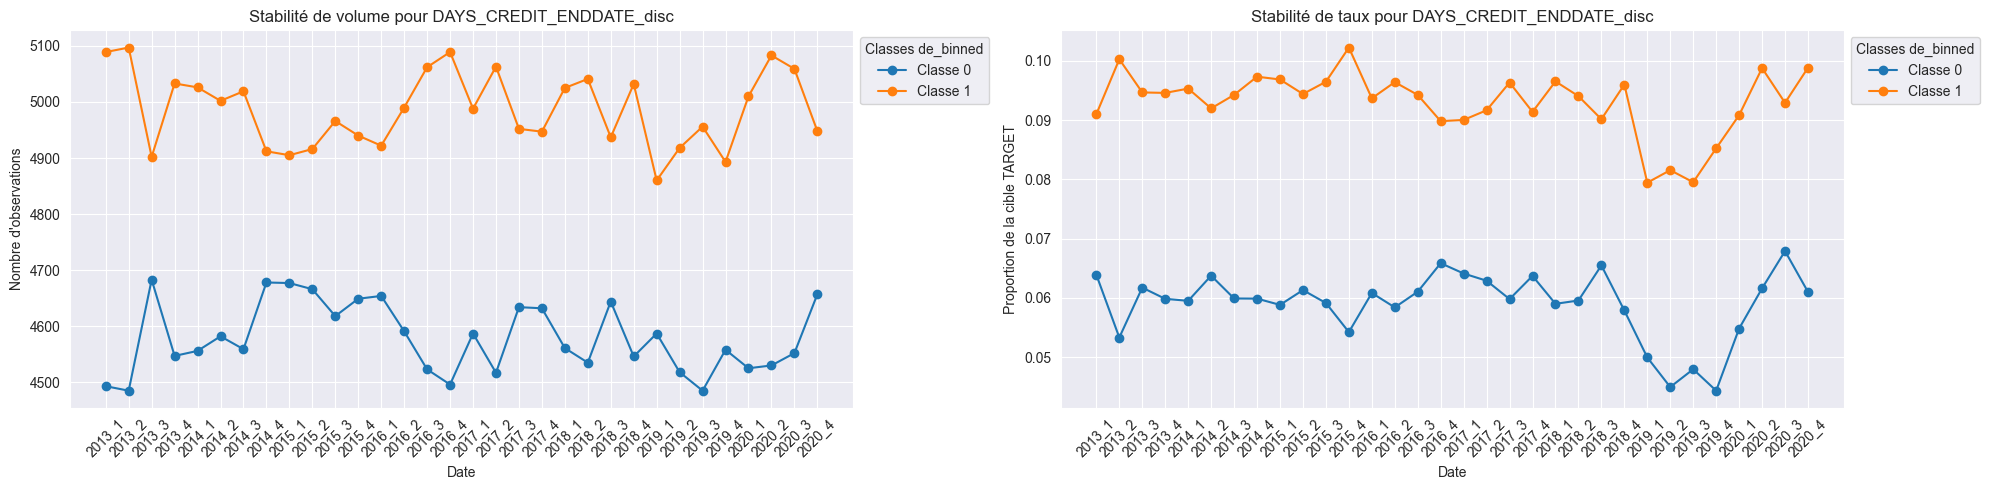

 43%|████▎     | 3/7 [00:54<01:11, 17.96s/it]

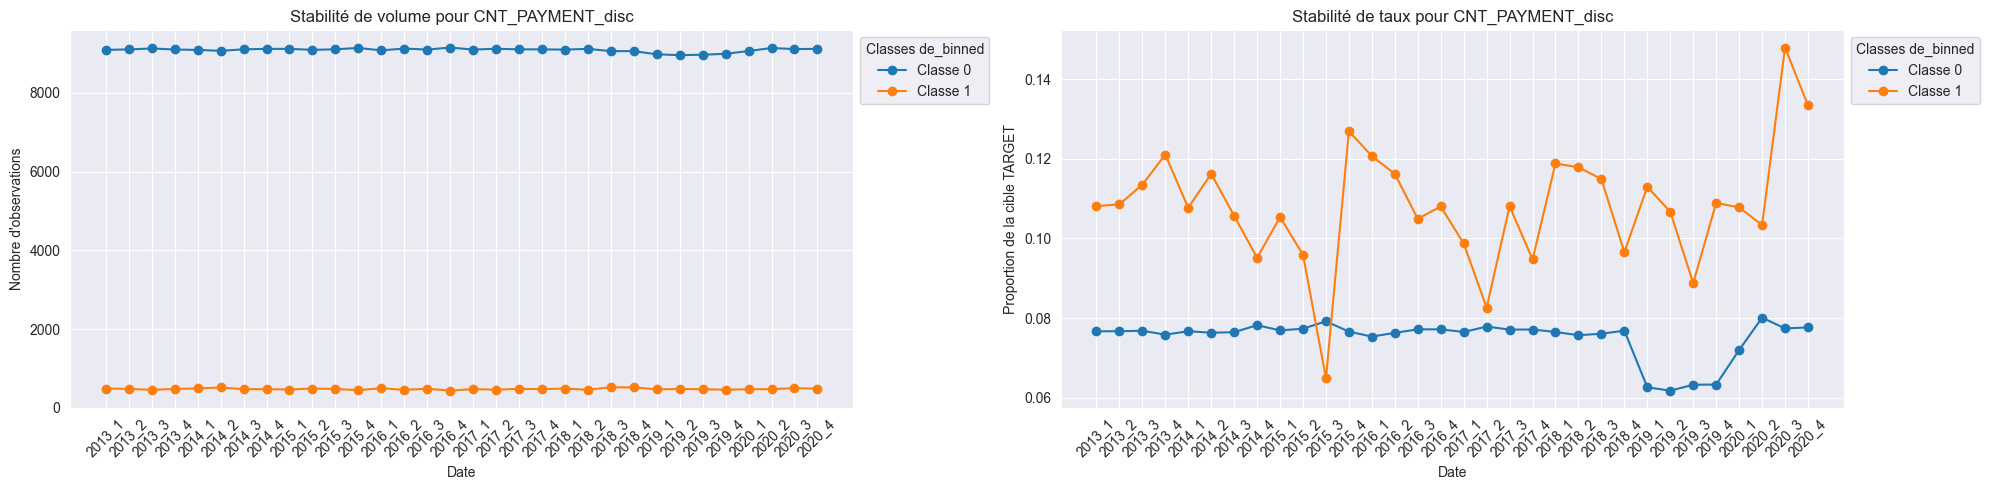

 57%|█████▋    | 4/7 [01:11<00:52, 17.39s/it]

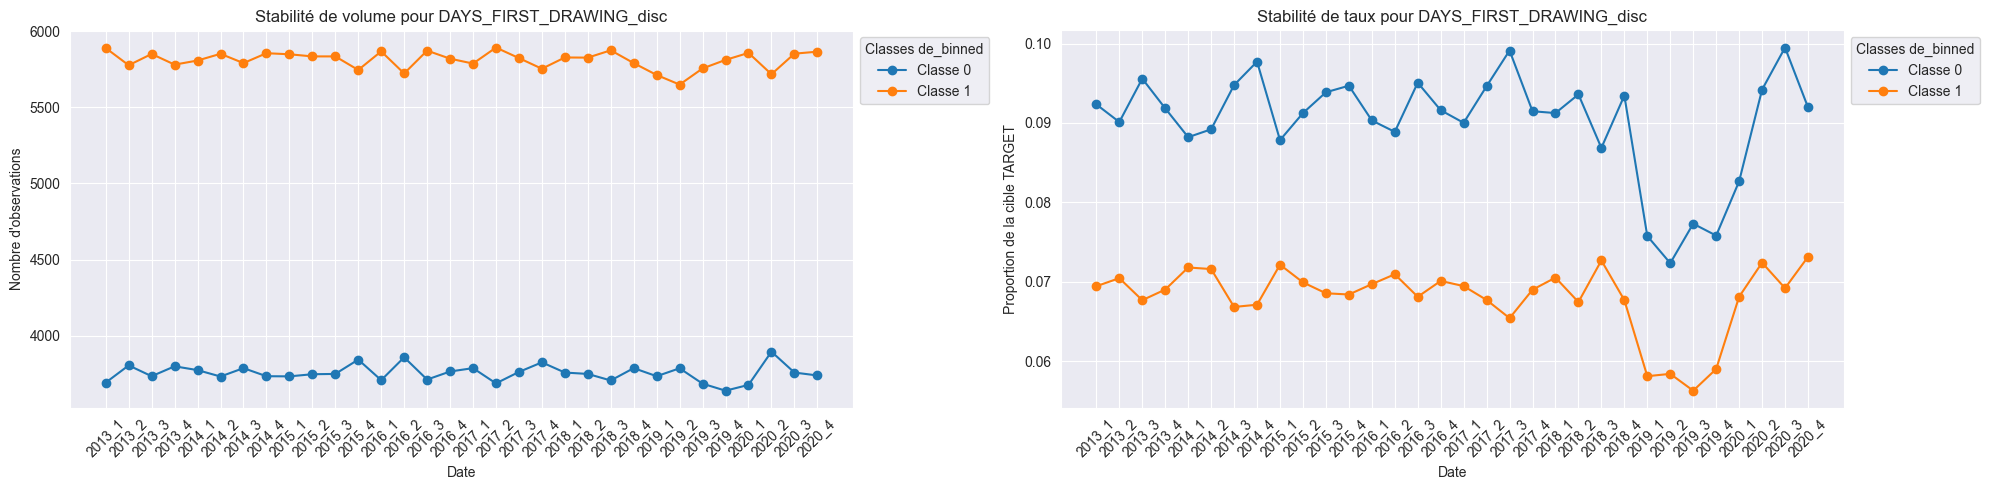

 71%|███████▏  | 5/7 [01:30<00:36, 18.02s/it]

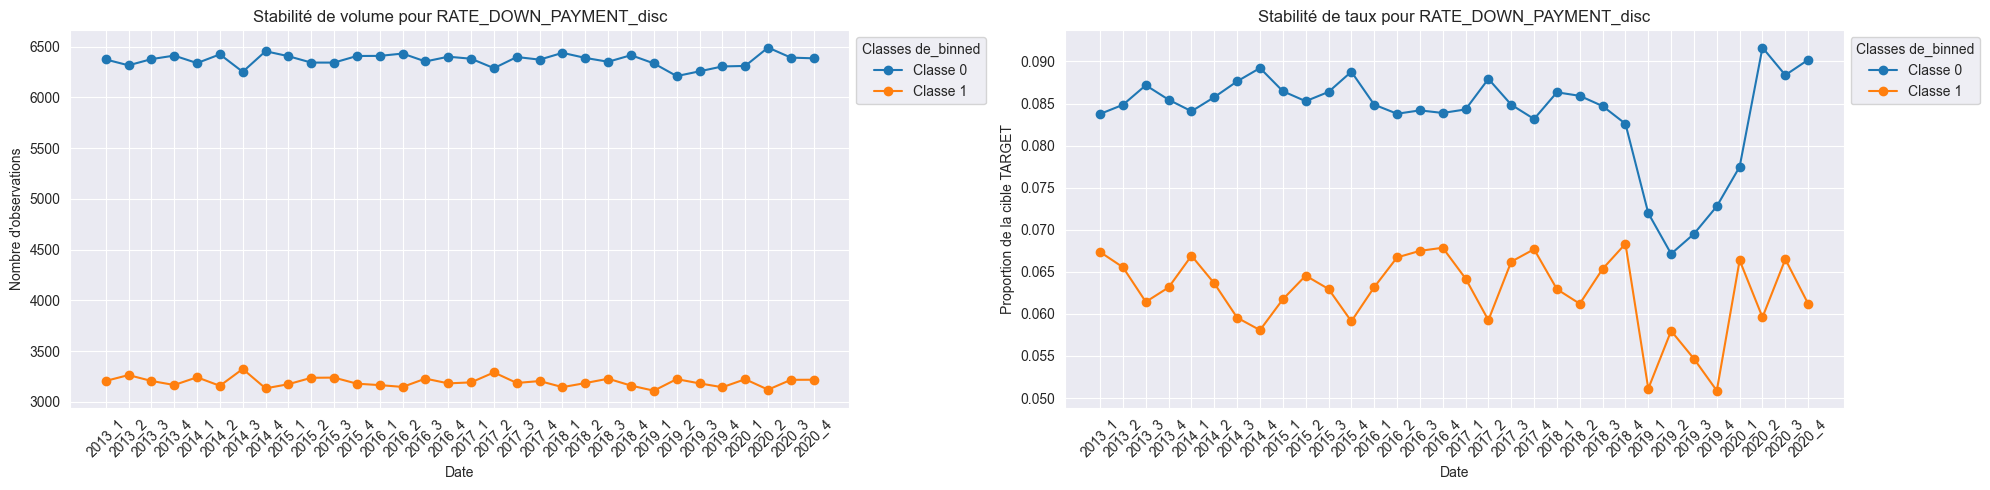

 86%|████████▌ | 6/7 [01:51<00:19, 19.24s/it]

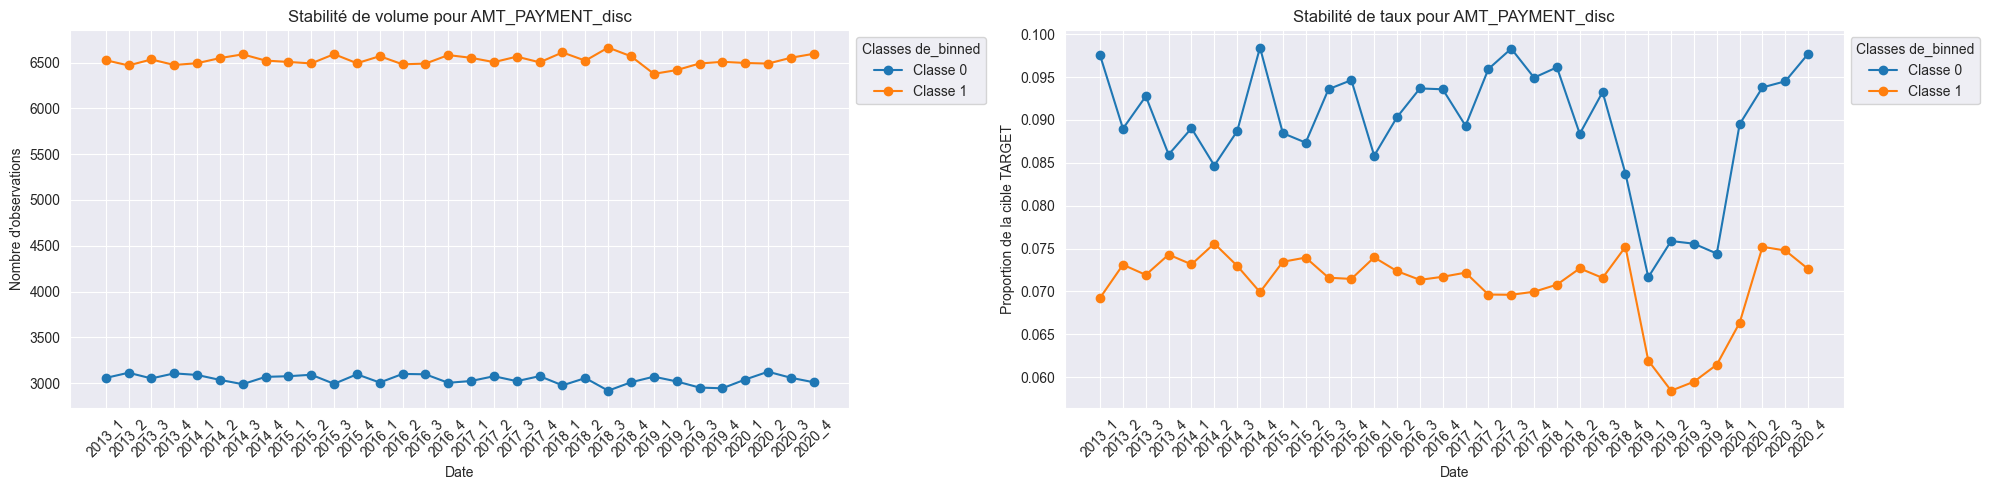

100%|██████████| 7/7 [02:10<00:00, 18.71s/it]

Variables numériques discrétisées ✅


In [90]:
dataprep = DataPreparation(train = train_prepared, nan_treshold = 0.4, plot = True)
dataprep.numericals_discretisation()

In [91]:
dataprep.categorical_discretisation()

Discrétisation des variables catégorielles en cours ... 


In [92]:
train_prepared_sauv = train_prepared.copy()

In [93]:
train_prepared = train_prepared_sauv.copy()

In [94]:
train_prepared = train_prepared[['SK_ID_CURR','REGION_RATING_CLIENT_W_CITY_disc',
       'REGION_RATING_CLIENT_W_CITY_disc_int', 'EXT_SOURCE_2_disc',
       'EXT_SOURCE_2_disc_int', 'DAYS_CREDIT_ENDDATE_disc',
       'DAYS_CREDIT_ENDDATE_disc_int',
       'CNT_PAYMENT_disc_int', 'DAYS_FIRST_DRAWING_disc',
       'DAYS_FIRST_DRAWING_disc_int', 'RATE_DOWN_PAYMENT_disc',
       'RATE_DOWN_PAYMENT_disc_int', 'AMT_PAYMENT_disc',
       'AMT_PAYMENT_disc_int', 'NAME_INCOME_TYPE_discret',
       'OCCUPATION_TYPE_discret','NAME_CONTRACT_TYPE','date_mensuelle','TARGET','DEF_30_CNT_SOCIAL_CIRCLE']]

In [95]:
train_prepared['NAME_INCOME_TYPE_discret'] = train_prepared['NAME_INCOME_TYPE_discret'].apply(lambda x : 'other' if x =='low_income' else x)

# Data viz

In [101]:
train_prepared['DEF_30_CNT_SOCIAL_CIRCLE'] = train_prepared['DEF_30_CNT_SOCIAL_CIRCLE'].astype('int')
train_prepared['DEF_30_CNT_SOCIAL_CIRCLE'] = train_prepared['DEF_30_CNT_SOCIAL_CIRCLE'].apply(lambda x : 1 if x !=0 else x)
train_prepared['DEF_30_CNT_SOCIAL_CIRCLE'] = train_prepared['DEF_30_CNT_SOCIAL_CIRCLE'].astype('object')

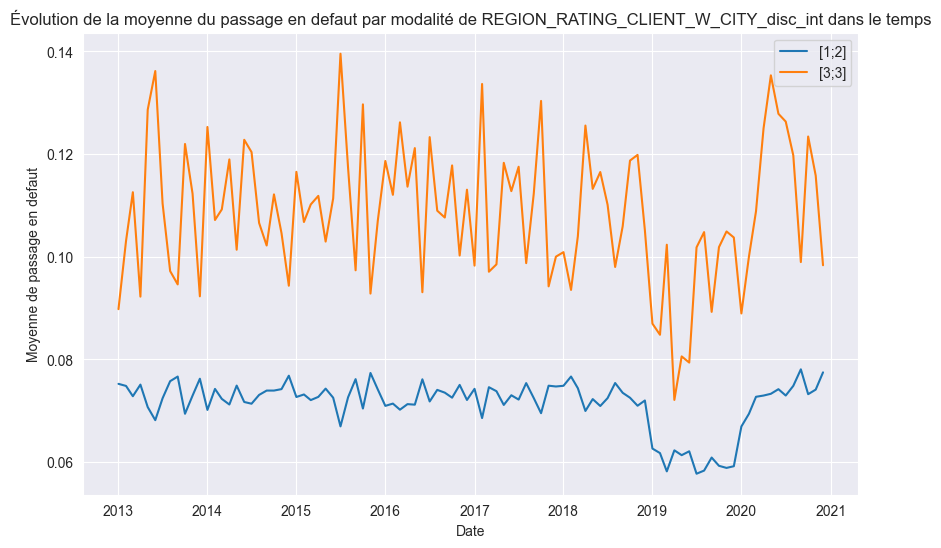

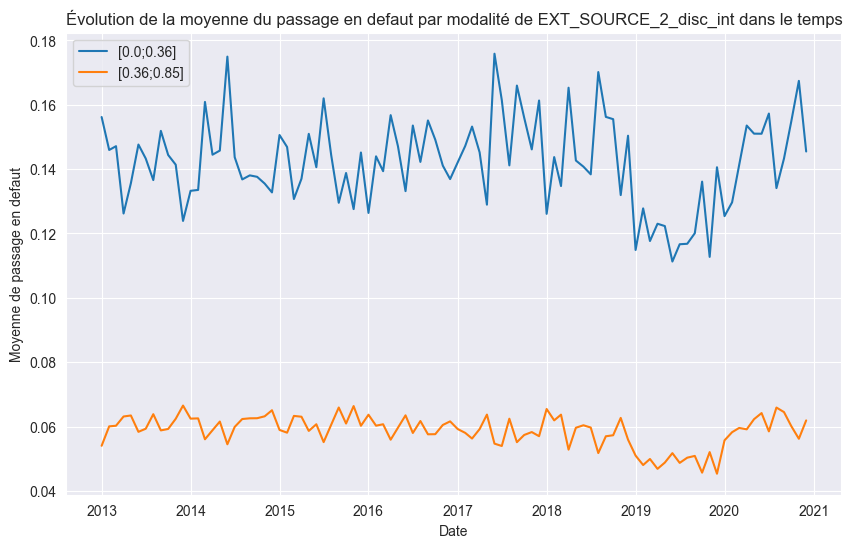

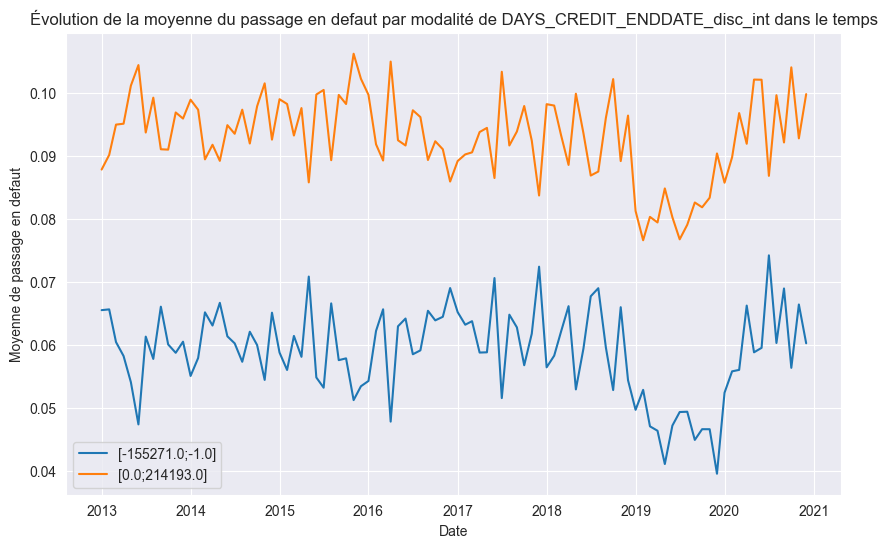

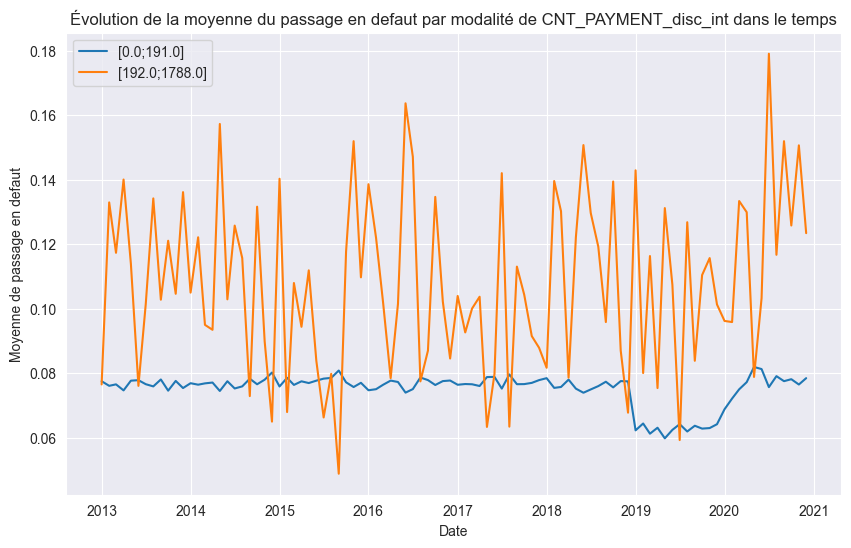

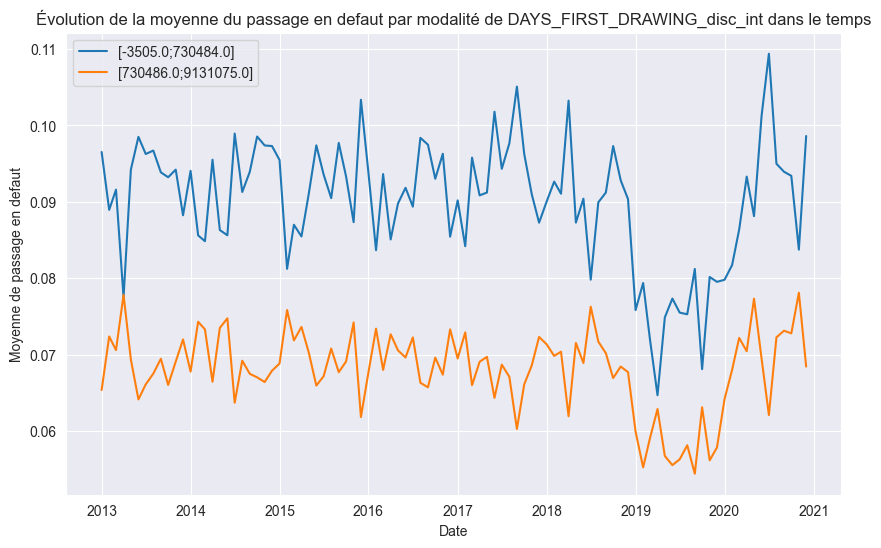

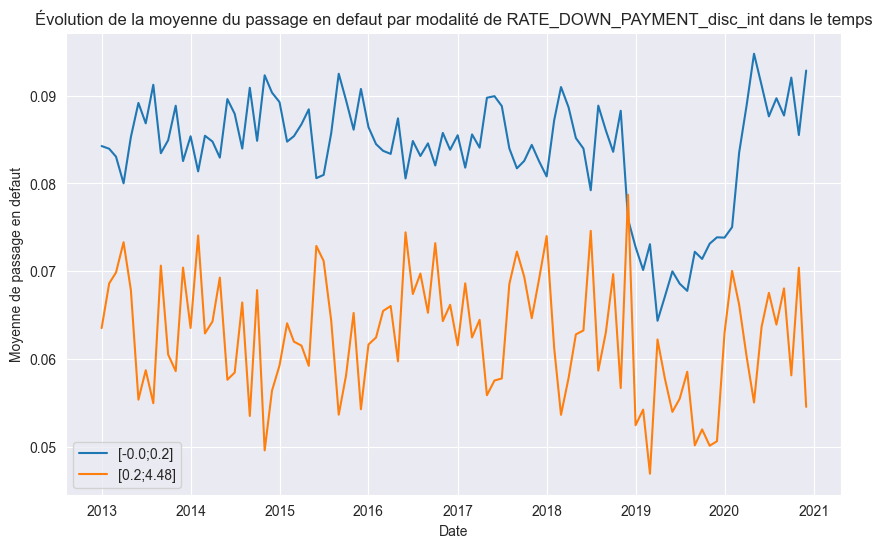

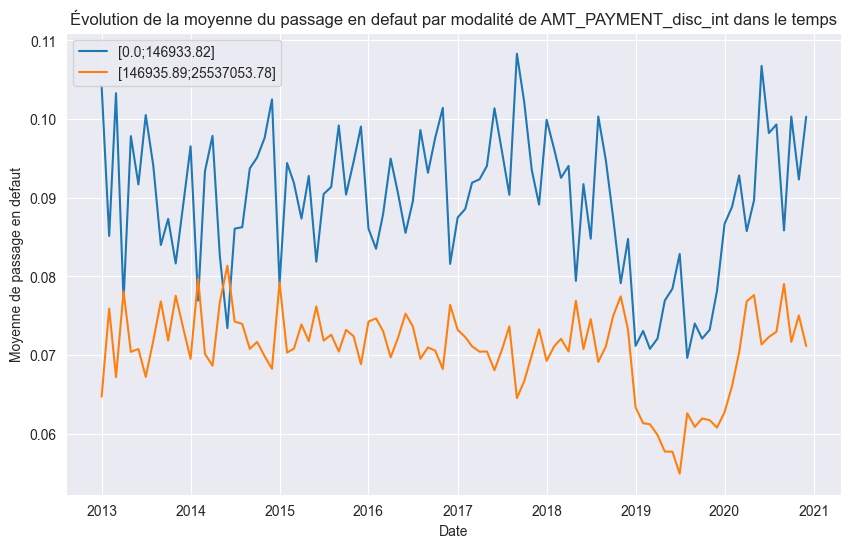

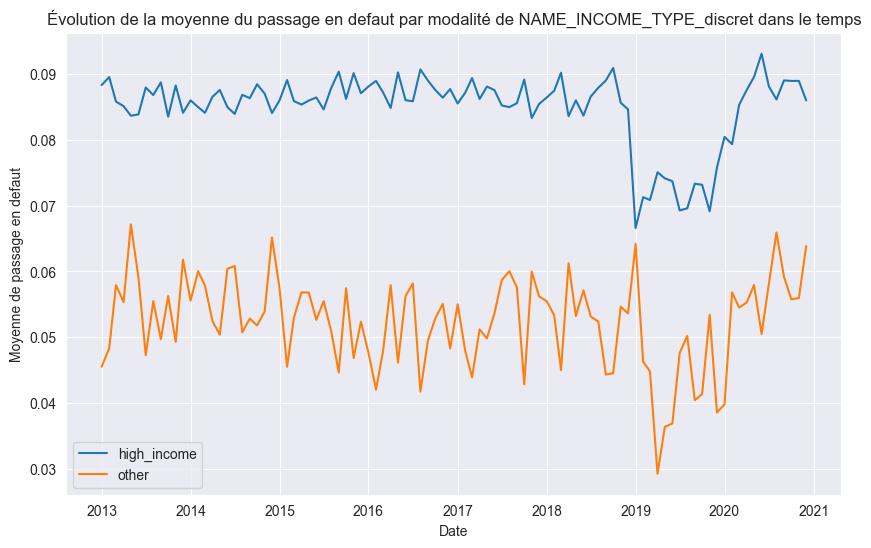

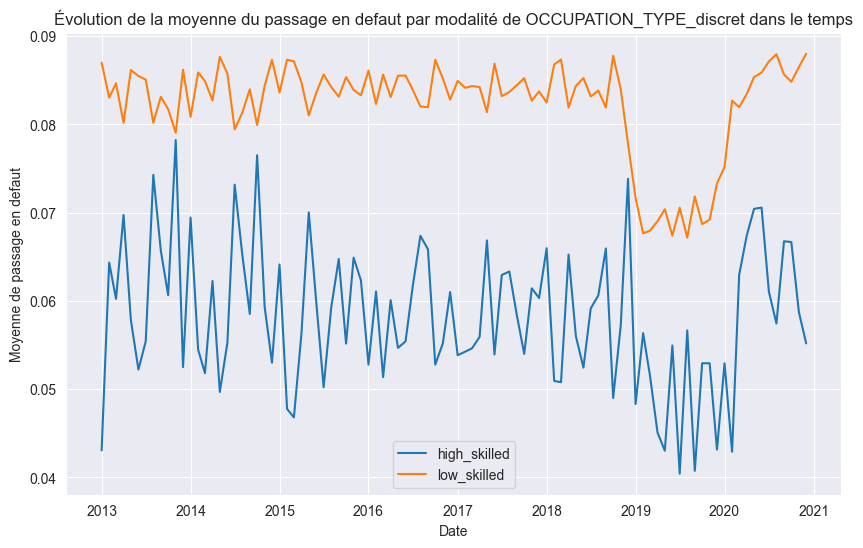

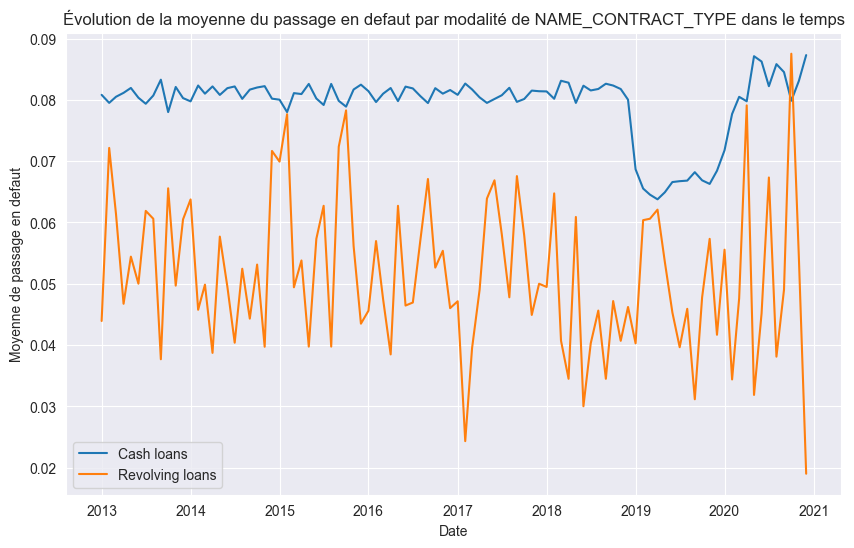

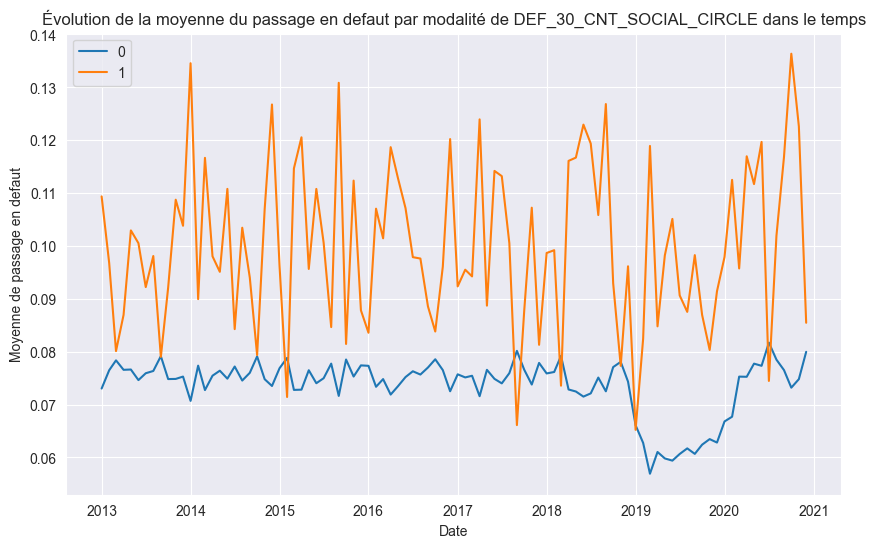

In [102]:
for col in train_prepared.select_dtypes(include = 'object').columns:
    result = train_prepared.groupby([col, 'date_mensuelle'])['TARGET'].mean().reset_index()
    fig, ax = plt.subplots(figsize=(10, 6))
    for genre, group in result.groupby(f'{col}'):
        ax.plot(group['date_mensuelle'], group['TARGET'], label=f'{genre}')
    ax.legend()
    ax.set_xlabel('Date')
    ax.set_ylabel('Moyenne de passage en defaut')
    ax.set_title(f'Évolution de la moyenne du passage en defaut par modalité de {col} dans le temps')
 
    plt.show()

In [103]:
X = train_prepared.drop(columns=['date_mensuelle'])
y = train_prepared['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)


# Logit statsmodels

Optimization terminated successfully.
         Current function value: 0.262981
         Iterations 7


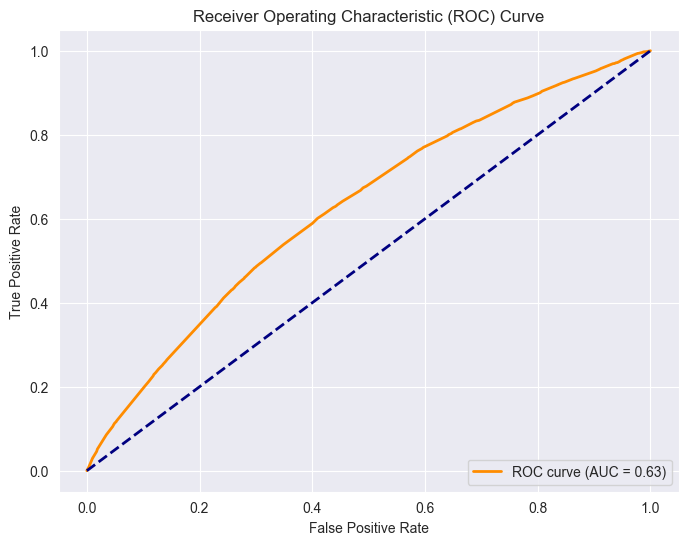

Gini : 0.2563777023869396 , AUC : 0.6281888511934698


In [104]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from statsmodels.discrete.discrete_model import Logit

features = ['REGION_RATING_CLIENT_W_CITY_disc', 'DAYS_CREDIT_ENDDATE_disc', 'RATE_DOWN_PAYMENT_disc', 'AMT_PAYMENT_disc', 'NAME_INCOME_TYPE_discret', 'OCCUPATION_TYPE_discret', 'NAME_CONTRACT_TYPE']


replacement_dict = {1: 'un', 0: 'zero', 2: 'deux', 3: 'trois'}

df_train = X_train.copy()
df_validation = X_test.copy()

for var in features:
   df_train[var] = df_train[var].replace(replacement_dict)
   df_validation[var] = df_validation[var].replace(replacement_dict)


df_train["TARGET"] = df_train["TARGET"].astype("int")


reference_categories = {var: df_train[var].mode()[0] for var in features}
formula_parts = []
for var in features:
    if var in reference_categories:
        ref_category = reference_categories[var]
        formula_parts.append(f'C({var}, Treatment(reference="{ref_category}"))')

formula = 'TARGET ~ ' + ' + '.join(formula_parts)

model = Logit.from_formula(formula=formula, data=df_train)
logit_model = model.fit()#_regularized(alpha = 1.5)

# Prédiction
pred = logit_model.predict(df_validation)
fpr, tpr, thresholds = roc_curve(df_validation["TARGET"],pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
roc_auc = auc(fpr, tpr)
gini_coefficient = 2 * roc_auc - 1
print(f'Gini : {gini_coefficient} , AUC : {roc_auc}')

In [48]:
round(logit_model.summary2().tables[1],2)


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,-2.11,0.01,-150.27,0.0,-2.14,-2.08
"C(REGION_RATING_CLIENT_W_CITY_disc, Treatment(reference=""zero""))[T.un]",0.46,0.02,23.62,0.0,0.42,0.50
"C(DAYS_CREDIT_ENDDATE_disc, Treatment(reference=""un""))[T.zero]",-0.47,0.02,-29.64,0.0,-0.50,-0.44
"C(RATE_DOWN_PAYMENT_disc, Treatment(reference=""zero""))[T.un]",-0.27,0.02,-15.42,0.0,-0.30,-0.23
"C(AMT_PAYMENT_disc, Treatment(reference=""un""))[T.zero]",0.23,0.02,13.94,0.0,0.20,0.26
"C(NAME_INCOME_TYPE_discret, Treatment(reference=""high_income""))[T.other]",-0.55,0.02,-27.49,0.0,-0.59,-0.51
"C(OCCUPATION_TYPE_discret, Treatment(reference=""low_skilled""))[T.high_skilled]",-0.41,0.02,-20.68,0.0,-0.45,-0.37
"C(NAME_CONTRACT_TYPE, Treatment(reference=""Cash loans""))[T.Revolving loans]",-0.54,0.03,-17.60,0.0,-0.61,-0.48


# Xgboost

In [145]:
train_prepared2 = train_prepared[['REGION_RATING_CLIENT_W_CITY_disc', 'DAYS_CREDIT_ENDDATE_disc', 'RATE_DOWN_PAYMENT_disc', 'AMT_PAYMENT_disc', 'NAME_INCOME_TYPE_discret', 'OCCUPATION_TYPE_discret', 'NAME_CONTRACT_TYPE','TARGET']].copy()

In [146]:
train_prepared2['NAME_INCOME_TYPE_discret_high_income'] = train_prepared2['NAME_INCOME_TYPE_discret'].apply(lambda x : 1 if x == 'high_income' else 0)
train_prepared2['RATE_DOWN_PAYMENT_[0;0.2]'] = train_prepared2['RATE_DOWN_PAYMENT_disc'].apply(lambda x : 1 if x == 0 else 0)
train_prepared2['AMT_PAYMENT_[0;146933]'] = train_prepared2['AMT_PAYMENT_disc'].apply(lambda x : 1 if x == 0 else 0)
train_prepared2['NAME_CONTRACT_TYPE_Cash_loans'] = train_prepared2['NAME_CONTRACT_TYPE'].apply(lambda x : 1 if x == 'Cash loans' else 0)
train_prepared2['OCCUPATION_TYPE_discret_low_skilled'] = train_prepared2['OCCUPATION_TYPE_discret'].apply(lambda x : 1 if x == 'low_skilled' else 0)

In [147]:
train_prepared2.drop(columns = ['OCCUPATION_TYPE_discret','NAME_CONTRACT_TYPE','AMT_PAYMENT_disc','RATE_DOWN_PAYMENT_disc','NAME_INCOME_TYPE_discret'],inplace = True)

In [148]:
train_prepared2.rename(columns = {'REGION_RATING_CLIENT_W_CITY_disc': 'REGION_RATING_CLIENT_W_CITY_[3;3]','DAYS_CREDIT_ENDDATE_disc' : 'DAYS_CREDIT_ENDDATE_[0;214193]'},inplace = True)

In [149]:
X = train_prepared2.drop(columns = ['TARGET'])
y = train_prepared2['TARGET']

X_train2, X_test2, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)


In [150]:
new_columns = []
for col in X_train2.columns:
    new_col = col.replace('[', 'zz').replace(']', 'vv').replace(';', 'ww').replace('-', 'ff').replace('.', 'pp')
    new_columns.append(new_col)

X_train2.columns = new_columns


new_columns = []
for col in X_test2.columns:
    new_col = col.replace('[', 'zz').replace(']', 'vv').replace(';', 'ww').replace('-', 'ff').replace('.', 'pp')
    new_columns.append(new_col)

X_test2.columns = new_columns

In [151]:
X_test2.columns 

Index(['REGION_RATING_CLIENT_W_CITY_zz3ww3vv',
       'DAYS_CREDIT_ENDDATE_zz0ww214193vv',
       'NAME_INCOME_TYPE_discret_high_income', 'RATE_DOWN_PAYMENT_zz0ww0pp2vv',
       'AMT_PAYMENT_zz0ww146933vv', 'NAME_CONTRACT_TYPE_Cash_loans',
       'OCCUPATION_TYPE_discret_low_skilled'],
      dtype='object')

In [152]:
import optuna
import xgboost as xgb
from sklearn.metrics import roc_auc_score

liste_var =X_train2.columns

def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',  # Utilisation de l'aire sous la courbe ROC comme métrique d'évaluation
        'max_depth': trial.suggest_int('max_depth', 4, 20),
        'eta': trial.suggest_loguniform('eta', 0.05, 0.4),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.3, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 90, 150),
        'alpha': trial.suggest_loguniform('alpha', 0.05, 1.0)
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train2[liste_var], y_train)
    y_pred_proba = model.predict_proba(X_test2[liste_var])[:, 1]  # Probabilité de la classe positive
    auc_score = roc_auc_score(y_test, y_pred_proba)  # Calcul de l'aire sous la courbe ROC
    return auc_score

# Create an Optuna study object and perform the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Display the optimization results
print(f"Best parameters: {study.best_params}")
print(f"Best positive f1 score: {study.best_value}")


[I 2024-02-27 10:48:06,299] A new study created in memory with name: no-name-8428425e-47cc-47f0-8a23-c9392eaf9684
[I 2024-02-27 10:48:07,795] Trial 0 finished with value: 0.6233696835860393 and parameters: {'max_depth': 19, 'eta': 0.2948754837163624, 'gamma': 1.6638940623102458e-08, 'colsample_bytree': 0.615557306663375, 'subsample': 0.6322377617370255, 'n_estimators': 95, 'alpha': 0.15439516676842827}. Best is trial 0 with value: 0.6233696835860393.
[I 2024-02-27 10:48:09,782] Trial 1 finished with value: 0.624502351572051 and parameters: {'max_depth': 20, 'eta': 0.09039346279705804, 'gamma': 0.1022394923288858, 'colsample_bytree': 0.44427941301462115, 'subsample': 0.9449338377441103, 'n_estimators': 104, 'alpha': 0.6050820852748322}. Best is trial 1 with value: 0.624502351572051.
[I 2024-02-27 10:48:11,917] Trial 2 finished with value: 0.6228267640886457 and parameters: {'max_depth': 8, 'eta': 0.16580815967129212, 'gamma': 0.03138405464861721, 'colsample_bytree': 0.9291043169676325, 

Best parameters: {'max_depth': 10, 'eta': 0.06739876573943267, 'gamma': 1.0887983081146109e-05, 'colsample_bytree': 0.5551288232191764, 'subsample': 0.9618418605416359, 'n_estimators': 97, 'alpha': 0.48989283547214435}
Best positive f1 score: 0.6248177551670132


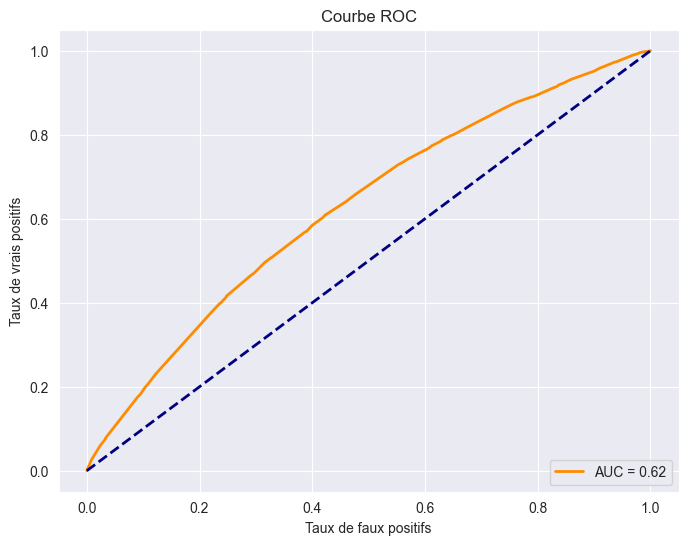

In [153]:
params = study.best_params

# Créer le modèle avec les hyperparamètres spécifiés
model = xgb.XGBClassifier(**params)

# Entraîner le modèle
model.fit(X_train2[liste_var], y_train)

# Faire des prédictions sur l'ensemble de test
y_prob = model.predict_proba(X_test2[liste_var])[:, 1]

# Calculer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Afficher la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

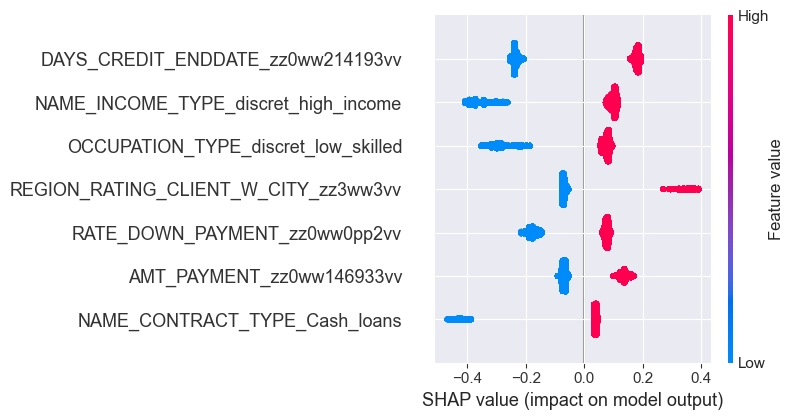

In [154]:
import shap
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_train2[liste_var])

shap.summary_plot(shap_values, X_train2[liste_var])

shap_values_single = explainer.shap_values(X_train2[liste_var].iloc[[0]])
shap.force_plot(explainer.expected_value, shap_values_single, X_train2[liste_var].iloc[[0]])

# Création de coefficients shapley values

In [59]:
shaps = pd.DataFrame(shap_values,columns = X_train2.columns)
shaps['TARGET'] = y_train.values

In [60]:
shaps

,REGION_RATING_CLIENT_W_CITY_disc,DAYS_CREDIT_ENDDATE_disc,RATE_DOWN_PAYMENT_disc,AMT_PAYMENT_disc,NAME_INCOME_TYPE_discret_other,OCCUPATION_TYPE_discret_low_skilled,NAME_CONTRACT_TYPE_Revolving loans,TARGET
0,-0.066720,-0.251011,0.065394,-0.066431,-0.412013,0.051475,0.035209,0.0
1,-0.070565,0.182007,-0.182797,-0.066050,0.105519,0.082628,0.041166,0.0
2,-0.066834,-0.232114,0.077214,0.165621,0.112255,0.093326,-0.428789,0.0
3,0.366480,-0.263360,0.084811,-0.071767,0.125953,0.078753,0.042268,0.0
4,-0.066605,-0.231165,-0.169437,-0.059263,0.082586,-0.278735,0.042980,0.0
...,...,...,...,...,...,...,...,...
244880,-0.064549,0.177453,0.066857,-0.071835,-0.392974,0.062623,-0.431893,0.0
244881,-0.075476,0.186962,0.079868,-0.067628,0.113611,0.083602,0.041977,0.0
244882,-0.069298,0.171578,-0.179001,-0.056885,0.079778,-0.296408,0.045657,0.0
244883,-0.071964,-0.251005,0.078079,-0.070711,0.115987,0.077677,0.039159,0.0


In [61]:
shaps[shaps['REGION_RATING_CLIENT_W_CITY_disc']>0]['REGION_RATING_CLIENT_W_CITY_disc'].mean()

0.35830802

In [ ]:
shapley_values = pd.DataFrame()


In [62]:
X =shaps.drop(columns = ['TARGET'])
y = shaps['TARGET']
X = sm.add_constant(X)

shap_train, shap_test, y_train_shap, y_test_shap = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

In [63]:
# Créer le modèle de régression logistique
logit_model = sm.Logit(y_train_shap, shap_train)

# Ajuster le modèle aux données
result = logit_model.fit()

# Afficher un résumé des résultats
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.263239
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 TARGET   No. Observations:               195908
Model:                          Logit   Df Residuals:                   195900
Method:                           MLE   Df Model:                            7
Date:                Mon, 26 Feb 2024   Pseudo R-squ.:                 0.02746
Time:                        22:40:11   Log-Likelihood:                -51571.
converged:                       True   LL-Null:                       -53027.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  -2.4979      0.009 

In [64]:
predicted_probabilities = result.predict(shap_test)

# Calculer l'AUC en utilisant les probabilités prédites et les vraies étiquettes de classe du jeu de test
auc = roc_auc_score(y_test_shap, predicted_probabilities)

print("AUC sur le jeu de test:", auc)

AUC sur le jeu de test: 0.6270340212349597
